In [1]:
#!/usr/bin/env python3
"""This file creates toy samples of ellipticities and saves them to .hdf5 file."""
import os
from functools import partial
from typing import Callable

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import blackjax
import click
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit as jjit
from jax import random, vmap
from jax.typing import ArrayLike

from bpd import DATA_DIR
from bpd.chains import inference_loop
from bpd.io import save_dataset
from bpd.prior import ellip_mag_prior, sample_synthetic_sheared_ellips_unclipped

import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)



In [2]:
import blackjax
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

In [3]:
def log_target(
    e_sheared: ArrayLike,
    e_obs: ArrayLike,
    sigma_m: float,
    interim_prior: Callable = None,
):
    assert e_sheared.shape == (2,) and e_obs.shape == (2,)

    # ignore angle because flat
    # prior enforces magnitude < 1.0 for posterior samples
    e_sheared_mag = jnp.sqrt(e_sheared[0] ** 2 + e_sheared[1] ** 2)
    prior = jnp.log(interim_prior(e_sheared_mag))

    likelihood = jnp.sum(jsp.stats.norm.logpdf(e_obs, loc=e_sheared, scale=sigma_m))
    return prior + likelihood


def do_inference(
    rng_key,
    init_positions: ArrayLike,
    e_obs: ArrayLike,
    sigma_m: float,
    sigma_e: float,
    k=10,
):
    interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
    _logtarget = partial(
        log_target, e_obs=e_obs, sigma_m=sigma_m, interim_prior=interim_prior
    )

    key1, key2 = random.split(rng_key)

    warmup = blackjax.window_adaptation(
        blackjax.nuts,
        _logtarget,
        progress_bar=False,
        is_mass_matrix_diagonal=True,
        max_num_doublings=2,
        initial_step_size=sigma_e,
        target_acceptance_rate=0.80,
    )

    (init_states, tuned_params), _ = warmup.run(key1, init_positions, 500)
    kernel = blackjax.nuts(_logtarget, **tuned_params).step
    states, _ = inference_loop(key2, init_states, kernel=kernel, n_samples=k)
    return states.position

In [4]:
seed = 41
sigma_e = 1e-2
sigma_m = 1e-3
g1 = 0.02
g2 = 0.00
n_samples = 100
k = 1_000
# md = 2
n_chains_per_gal = 4



rng_key = random.key(seed)

k1, k2 = random.split(rng_key)

true_g = jnp.array([g1, g2])



e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
    k1, true_g, n=n_samples, sigma_m=sigma_m, sigma_e=sigma_e
)
e_obs.shape

2024-10-01 15:30:53.034826: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(100, 2)

In [5]:
keys2 = random.split(k2, n_samples * n_chains_per_gal).reshape(n_samples, n_chains_per_gal)

In [6]:
keys2.shape

(100, 4)

In [7]:
_do_inference_jitted = jjit(
    partial(do_inference, sigma_e=sigma_e, sigma_m=sigma_m, k=k)
)
_do_inference = vmap(vmap(_do_inference_jitted, in_axes=(0, None, None)), in_axes=(0, 0, 0) )

In [8]:
# compile
_ = _do_inference(keys2[:2], e_sheared[:2], e_obs[:2])

In [9]:
e_post = _do_inference(keys2, e_sheared, e_obs)
e_post.shape

(100, 4, 1000, 2)

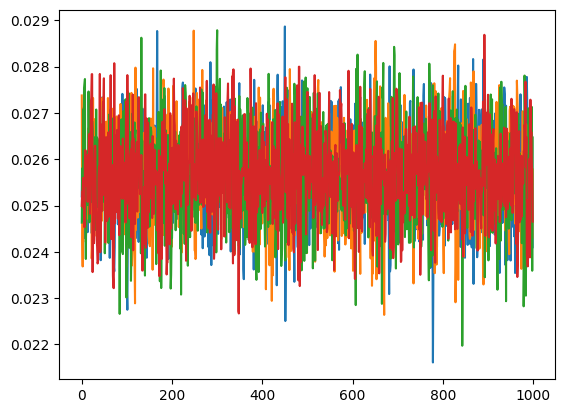

In [10]:
for ii in range(4): 
    plt.plot(e_post[0, ii, :, 0])

In [19]:
all_ess = []
for ii in range(100):
    ess = effective_sample_size(e_post[ii, :, :, 0], chain_axis=0, sample_axis=1)
    # print(ess)
    # print(ess / 4000)
    all_ess.append(ess/4000)
    # print(potential_scale_reduction(e_post[ii, :, :, 0], chain_axis=0, sample_axis=1))
    # print()
    
for ii in range(100):
    ess = effective_sample_size(e_post[ii, :, :, 1], chain_axis=0, sample_axis=1)
    # print(ess)
    # print(ess / 4000)
    all_ess.append(ess/4000)
    # print(potential_scale_reduction(e_post[ii, :, :, 0], chain_axis=0, sample_axis=1))
    # print()

(array([ 1.,  0.,  0.,  4.,  0.,  3.,  3.,  8., 11., 14., 11.,  7., 27.,
        21., 14., 21., 15., 20.,  8.,  6.,  3.,  0.,  1.,  0.,  2.]),
 array([0.69964554, 0.71599437, 0.73234321, 0.74869204, 0.76504088,
        0.78138971, 0.79773855, 0.81408738, 0.83043622, 0.84678505,
        0.86313389, 0.87948272, 0.89583156, 0.91218039, 0.92852923,
        0.94487806, 0.9612269 , 0.97757573, 0.99392457, 1.0102734 ,
        1.02662224, 1.04297107, 1.05931991, 1.07566874, 1.09201758,
        1.10836641]),
 <BarContainer object of 25 artists>)

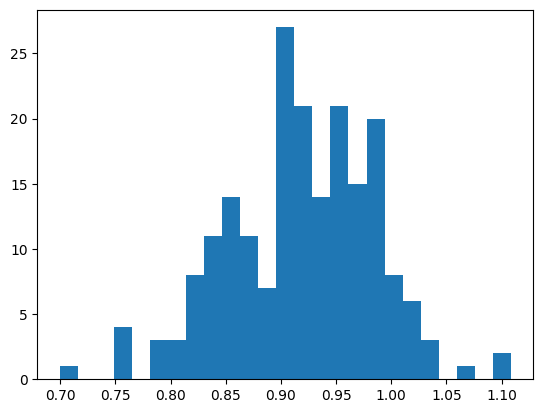

In [21]:
plt.hist(all_ess, bins=25) # should be more than safe triming by >4/5

# Check saved

In [71]:
from bpd.io import load_dataset

In [77]:
ds = load_dataset('../data/e_post_42_4.npz')

In [78]:
e_post1 = ds['e_post']

In [79]:
e_post1.shape

(1000000, 50, 2)

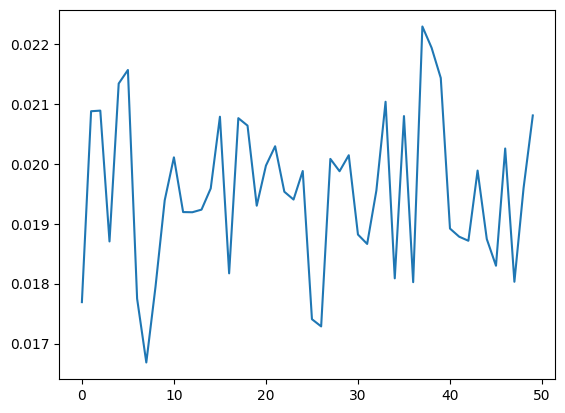

In [80]:
plt.plot(e_post1[0, :, 0])